# Sentiment Analysis

Hi 🙂, if you are seeing this notebook, you've succesfully started your first project on FloydHub, hooray! 🚀

[Sentiment analysis](https://en.wikipedia.org/wiki/Sentiment_analysis) is one of the most common [NLP](https://en.wikipedia.org/wiki/Natural-language_processing) problems. The goal is to analyze a text and predict whether the underlying sentiment is positive, negative or neutral. 
*What can you use it for?* Here are a few ideas - measure sentiment of customer support tickets, survey responses, social media, and movie reviews! 

### Predicting sentiment of movie reviews

In this notebook we will build a [Convolutional Neural Network](http://www.wildml.com/2015/11/understanding-convolutional-neural-networks-for-nlp/) (CNN) classifier to predict the sentiment (positive or negative) of movie reviews. 

<img src="https://github.com/floydhub/sentiment-analysis-template/raw/master/images/sentiment.jpg" width="800" height="800" align="center"/>

We will use the [Stanford Large Movie Reviews](http://ai.stanford.edu/~amaas/data/sentiment/) dataset for training our model. The dataset is compiled from a collection of 50,000 reviews from IMDB. It contains an equal number of positive and negative reviews. The authors considered only highly polarized reviews. Negative reviews have scores ≤ 4 (out of 10), while positive reviews have score ≥ 7. Neutral reviews are not included. The dataset is divided evenly into training and test sets.

We will:
- Preprocess text data for NLP
- Build and train a 1-D CNN using Keras and Tensorflow
- Evaluate our model on the test set
- Run the model on your own movie reviews!

### Instructions

- To execute a code cell, click on the cell and press `Shift + Enter` (shortcut for Run).
- To learn more about Workspaces, check out the [Getting Started Notebook](get_started_workspace.ipynb).
- **Tip**: *Feel free to try this Notebook with your own data and on your own super awesome sentiment classification task.*

Now, let's get started! 🚀

## Initial Setup

Let's start by importing some packages

In [1]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, GlobalMaxPooling1D, Flatten, Conv1D, Dropout, Activation
from keras.preprocessing.text import Tokenizer

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os
import re
import string

Using TensorFlow backend.


## Training Parameters

We'll set the hyperparameters for training our model. If you understand what they mean, feel free to play around - otherwise, we recommend keeping the defaults for your first run 🙂

In [2]:
# Hyperparams if GPU is available
if tf.test.is_gpu_available():
    # GPU
    BATCH_SIZE = 128 # Number of examples used in each iteration
    EPOCHS = 2 # Number of passes through entire dataset
    VOCAB_SIZE = 30000 # Size of vocabulary dictionary
    MAX_LEN = 500 # Max length of review (in words)
    EMBEDDING_DIM = 40 # Dimension of word embedding vector

# Hyperparams for CPU training
else:
    # CPU
    BATCH_SIZE = 32
    EPOCHS = 2
    VOCAB_SIZE = 20000
    MAX_LEN = 90
    EMBEDDING_DIM = 40

## Data

The movie reviews dataset is already attached to your workspace (if you want to attach your own data, [check out our docs](https://docs.floydhub.com/guides/workspace/#attaching-floydhub-datasets)).

Let's take a look at data. The labels are encoded in the dataset: **0** is for *negative* and **1** for a *positive* review.

In [3]:
DS_PATH = '/floyd/data/imdb/' # ADD path/to/dataset
LABELS = ['negative', 'positive']

# Load data
train = pd.read_csv(os.path.join(DS_PATH, "train.tsv"), sep='\t')  # EDIT WITH YOUR TRAIN FILE NAME
val = pd.read_csv(os.path.join(DS_PATH, "val.tsv"), sep='\t')  # EDIT WITH YOUR VALIDATION FILE NAME

print("Train shape (rows, columns): ", train.shape, ", Validation shape (rows, columns): ",  val.shape)

# How a row/sample looks like
print("\n--- First Sample ---")
print('Label:', train['label'][0])
print('Text:', train['text'][0])

Train shape (rows, columns):  (25000, 2) , Validation shape (rows, columns):  (25000, 2)

--- First Sample ---
Label: 0
Text: Watch the Original with the same title from 1944! This made for TV movie, is just god-awful! Although it does use (as far as I can tell) almost the same dialog, it just doesn't work! Is it the acting, the poor directing? OK so it's made for TV, but why watch a bad copy, when you can get your hands on the superb original? Especially as you'll be spoiled to the plot and won't enjoy the original as much, as if you've watched it first! <br /><br />There are a few things that are different from the original (it's shorter for once), but all are for the worse! The actors playing the parts here, just don't fit the bill! You just don't believe them and who could top Edward G. Robinsons performance from the original? If you want, only watch it after you've seen the original and even then you'll be very brave, if you watch it through! It's almost sacrilege!


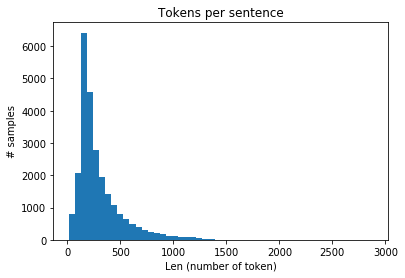

In [4]:
# Custom Tokenizer
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

# Plot sentence by lenght
plt.hist([len(tokenize(s)) for s in train['text'].values], bins=50)
plt.title('Tokens per sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

## Data Preprocessing

Before feeding the data into the model, we have to preprocess the text. 

- We will use the Keras `Tokenizer` to convert each word to a corresponding integer ID. Representing words as integers saves a lot of memory!
- In order to feed the text into our CNN, all texts should be the same length. We ensure this using the `sequence.pad_sequences()` method and `MAX_LEN` variable. All texts longer than `MAX_LEN` are truncated and shorter texts are padded to get them to the same length.

The *Tokens per sentence* plot (see above) is useful for setting the `MAX_LEN` training hyperparameter. 

In [5]:
imdb_tokenizer = Tokenizer(num_words=VOCAB_SIZE)
imdb_tokenizer.fit_on_texts(train['text'].values)

x_train_seq = imdb_tokenizer.texts_to_sequences(train['text'].values)
x_val_seq = imdb_tokenizer.texts_to_sequences(val['text'].values)

x_train = sequence.pad_sequences(x_train_seq, maxlen=MAX_LEN, padding="post", value=0)
x_val = sequence.pad_sequences(x_val_seq, maxlen=MAX_LEN, padding="post", value=0)

y_train, y_val = train['label'].values, val['label'].values

print('First sample before preprocessing: \n', train['text'].values[0], '\n')
print('First sample after preprocessing: \n', x_train[0])

First sample before preprocessing: 
 Watch the Original with the same title from 1944! This made for TV movie, is just god-awful! Although it does use (as far as I can tell) almost the same dialog, it just doesn't work! Is it the acting, the poor directing? OK so it's made for TV, but why watch a bad copy, when you can get your hands on the superb original? Especially as you'll be spoiled to the plot and won't enjoy the original as much, as if you've watched it first! <br /><br />There are a few things that are different from the original (it's shorter for once), but all are for the worse! The actors playing the parts here, just don't fit the bill! You just don't believe them and who could top Edward G. Robinsons performance from the original? If you want, only watch it after you've seen the original and even then you'll be very brave, if you watch it through! It's almost sacrilege! 

First sample after preprocessing: 
 [   5    1  111    2  525  354    1  201   14   73   14   44  871 

## Model

We will implement a model similar to Kim Yoon’s [Convolutional Neural Networks for Sentence Classification](https://arxiv.org/abs/1408.5882).

![cnn for text](https://github.com/floydhub/sentiment-analysis-template/raw/master/images/cnn.png)
*Image from [the paper](https://arxiv.org/abs/1408.5882)*

In [6]:
# Model Parameters - You can play with these

NUM_FILTERS = 250
KERNEL_SIZE = 3
HIDDEN_DIMS = 250

In [7]:
# CNN Model
print('Build model...')
model = Sequential()

# we start off with an efficient embedding layer which maps
# our vocab indices into EMBEDDING_DIM dimensions
model.add(Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_LEN))
model.add(Dropout(0.2))

# we add a Convolution1D, which will learn NUM_FILTERS filters
model.add(Conv1D(NUM_FILTERS,
                 KERNEL_SIZE,
                 padding='valid',
                 activation='relu',
                 strides=1))

# we use max pooling:
model.add(GlobalMaxPooling1D())

# We add a vanilla hidden layer:
model.add(Dense(HIDDEN_DIMS))
model.add(Dropout(0.2))
model.add(Activation('relu'))

# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Build model...
Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 90, 40)            800000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 90, 40)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 88, 250)           30250     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 250)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 250)               62750     
_________________________________________________________________
dropout_2 (Dropout)          (None, 250)               0         
____________________________________________

## Train & Evaluate

If you left the default hyperpameters in the Notebook untouched, your training should take approximately: 

- On CPU machine: 2 minutes for 2 epochs.
- On GPU machine: 1 minute for 2 epochs.

You should get an accuracy of > 84%. *Note*: The model will start overfitting after 2 to 3 epochs. 

In [8]:
# fit a model
model.fit(x_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_split=0.1)

# Evaluate the model
score, acc = model.evaluate(x_val, y_val, batch_size=BATCH_SIZE)
print('\nAccuracy: ', acc*100)

pred = model.predict_classes(x_val)

Train on 22500 samples, validate on 2500 samples
Epoch 1/2
22500/22500 [==============================] - 39s 2ms/step - loss: 0.4782 - acc: 0.7497 - val_loss: 0.3681 - val_acc: 0.8384
Epoch 2/2
25000/25000 [==============================] - 4s 141us/step

Accuracy:  85.044


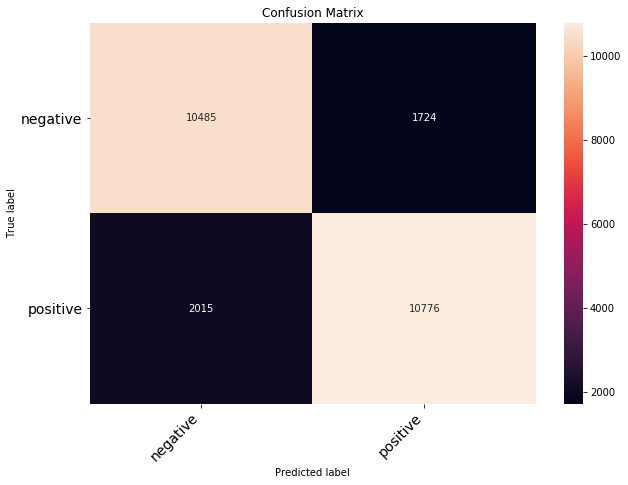

In [9]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix
from support import print_confusion_matrix
cnf_matrix = confusion_matrix(pred, y_val)
_ = print_confusion_matrix(cnf_matrix, LABELS)

In [10]:
# Print Precision Recall F1-Score Report
from sklearn.metrics import classification_report

report = classification_report(pred, y_val, target_names=LABELS)
print(report)

             precision    recall  f1-score   support

   negative       0.84      0.86      0.85     12209
   positive       0.86      0.84      0.85     12791

avg / total       0.85      0.85      0.85     25000



## It's your turn

Test out the model you just trained. Run the code Cell below and type your reviews in the widget, Have fun!🎉

Here are some inspirations:

- Epic in scope while maintaining intimacy characteristic of European art cinema, rightly considered one of the greatest films ever made.
- Rian Johnson\'s Star Wars: The Last Jedi is a satisfying, at times transporting entertainment with visual wit and a distinctly human touch. 
- All evidence points to this animated film being contrived as a money-making scheme. The result is worse than crass, it\'s abominably bad.
- It was inevitable that there would be the odd turkey in there. What I didn\'t realise however, was that there could be one THIS bad.

And some wrong predictions:
- Pulp Fiction: Quentin Tarantino proves that he is the master of witty dialogue and a fast plot that doesn\'t allow the viewer a moment of boredom or rest.

Can you do better? Play around with the model hyperparameters!

In [11]:
from ipywidgets import interact_manual
from ipywidgets import widgets

def get_prediction(review):
    # Preprocessing
    review_np_array = imdb_tokenizer.texts_to_sequences([review])
    review_np_array = sequence.pad_sequences(review_np_array, maxlen=MAX_LEN, padding="post", value=0)
    # Prediction
    score = model.predict(review_np_array)[0][0]
    prediction = LABELS[model.predict_classes(review_np_array)[0][0]]
    print('REVIEW:', review, '\nPREDICTION:', prediction, '\nSCORE: ', score)

interact_manual(get_prediction, review=widgets.Textarea(placeholder='Type your Review here'));

interactive(children=(Textarea(value='', description='review', placeholder='Type your Review here'), Button(de…

## Save the result

In [12]:
import pickle

# Saving Tokenizer
with open('models/tokenizer.pickle', 'wb') as handle:
    pickle.dump(imdb_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
 
# Saving Model Weight
model.save_weights('models/cnn_sentiment_weights.h5')